In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

font = {"size": 24}

plt.rc("font", **font)

## Creating the initial optic

We start with creating a conical lens defaulted to be a parabola (k=-1) with N=1000 points to span the space of the top half of the lens. One can start with other conical shapes by inputting the corresponding k value. The inputs are `thick` or the thickness of the lens and `R` which is the radius of curvature. The code only simulates the top half of the optic due to the assumption that the surface is cylindrically symmetric. The equation of the optic is derived from the equation for a conic section with the apex at the origin and solving for r:

\begin{align}
    r^2-2Rz+(K+1)z^2=0\\
    r=\sqrt{2Rz+(K+1)z^2}
\end{align}

One can plug in:
- k=-1 for parabola
- k=0 for spherical
- k>0 for oblate ellipse
- 0>K>−1 for prolate ellipse
- k<-1 for hyperbola

When plugging in the the values for `thick` and `R` one should keep in mind the thin lens approximation where the thickness << R

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.geomspace(1e-6,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

## Finding the slope for refraction/reflection

The goal of this is to find the normal to any shaped surface. The normal slope will be 1/m for reflected and -1/m for refracted where m is the tangent/slope of the surface at that point

In [3]:
def find_local_eq(r,optic,N=1000):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-5
    upper=index+5
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    # Use cubic spline to interpolate the local points
    cs=CubicSpline(local_z,local_opt)
    zs=np.linspace(local_z[0],local_z[-1],N)
    return zs,cs

In [4]:
def find_norm(z,cs):
    # find the normal to the surface
    tang=cs(z,1) # 1st derivative of the spline at point z
    norm=-1/tang
    return norm

`find_reflect_slope` takes the given normal slope to calculate the angle 2$\theta$ where $\theta$ is the angle that the incoming ray makes with the normal to the surface. 

In [5]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

`find__refract_slope` finds the slope of the ray after it refracts off of the surface. `norm` is the normal of the surface and is used to find the angle $\phi_1$ which is the angle between the incident ray and the normal of the surface. This function returns the slope of the ray that refracts after encountering the surface using Snell's law 

In [6]:
def find_refract_slope(norm,n1,n2):
    phi1=np.arctan(norm)
    sinphi2=n1*np.sin(phi1)/n2
    phi2=np.arcsin(sinphi2)
    theta=phi1-phi2
    slope=np.tan(theta)
    return slope

## Raytracing

Now that we have the algorithm to find the slope normal to the surface we can simulate the ray propagation. We only need to calculate for two points:where the ray meets the surface the optic and where the ray crosses the optical axis. Additional functionality can be added later for multiple optics. Also need to change the input rays to be ray vectors instead. This code does both refraction and reflection.

In [7]:
def raytrace(optic, Nr=7, refract=False):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[5]
    r_max=opt[-10]
    
    rays=np.linspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        zs,cs=find_local_eq(r,optic)
        z_optic=cs.roots()
        if len(z_optic)>1:
            print('Warning: multiple intersections with lens found') # many roots are usually found near r=0
        
        norm=find_norm(z_optic[0],cs)
        slope=find_refract_slope(norm,1,3) if refract else find_reflect_slope(norm)
        z_after=(-r/slope+z_optic[0]) # This is where the ray should intersect the z axis
        z_bef=-1 if refract else z_after*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic[0],z_after]
        r_ray=[r,r,0]            
        raymatrix.append([z_ray,r_ray])
        after.append(z_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [8]:
def plot(optic,raymatrix,exp_f,title, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    if savefig:
        plt.savefig(title+".png")
    plt.show()


## `create_hist`
Creates a histogram of where the rays meet on the z axis after the ray encounters the optic. The function uses [Sturge's Formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) to calculate the number of bins. We use the Rayleigh criterion as the bin width: $\Delta\theta = 1.22\lambda/D$ 

$1.22 f\#*\lambda$ 

$f\#=f/D$
where $\lambda$ is the wavelength and $D$ is the diameter of the optic. This is calculated with the function `calc_bw`. This function also rounds to the nearest 6th decimal by default which corresponds to the nearest micrometer for the physical case we've defined later in this notebook.  We set the bin number to be odd so that we have the expected focal length bin always as our center bar (this may need to be altered). We set the range as the $[f_{exp} - \frac{1}{2}k \Delta\theta, f_{exp} + \frac{1}{2}k\Delta\theta]$. 

7/5/22

We've decided to instead use fractions of the Rayleigh Length $z_R=\frac{\pi w_0^2}{\lambda}=1/2 k w_0^2$

In [9]:
def calc_bw(lambda0,diam,dec=6):
    ang_res= 1.22*lambda0/diam # The bin width is set as the minimum resolution 
    return np.around(ang_res,dec) 

In [10]:
def create_hist(rays_after,exp_f, bin_width, plot=False, lambda0=None, norm=False, savefig=False):
    n=len(rays_after)    
    #make k odd so that we have even number of bin below and above the expected focal value
    k=int(np.ceil(np.log2(n)))+1
    if k%2==0:
        k+=1
    
    bw=bin_width if not norm else bin_width/lambda0
    exp_freq=exp_f if not norm else exp_f/lambda0
    bin_low=exp_freq-bw*(0.5*k)
    bin_high=exp_freq+bw*(0.5*k)
    
    bins=np.linspace(bin_low,bin_high,k+1)
    
    rays = rays_after if not norm else rays_after/lambda0
    #hist=np.histogram(rays,bins)
    hist,bin_range=np.histogram(rays,bins)

    #plots the histogram
    if plot:
        fig,ax=plt.subplots(figsize=(15,10))
        ax.hist(rays,bins)
        xl='z (m)' if not norm else 'z/lambda'
        ax.set_xlabel(xl)
        ax.ticklabel_format(useOffset=False)
        ax.set_xticks(bins)
        title="Expected f: %f m" % (exp_f)
        ax.set_title(title)
        if savefig:
            plt.savefig(title+"_hist.png")

        plt.show()
    
    h=np.array(hist)
    return h

## The cost function

The cost function is the chi-square goodness-of-fit test which is shown below:

\begin{equation}
    \chi^2=\sum_{i=1}^{k}(O_i-E_i)^2
\end{equation}

where $O_i$ is the observed frequency for bin $i$ and $E_i$ is the expected frequency for bin $i$. For our case we want to have all of our rays meet at the same point i.e have them all in the same bin. Therefore, the expected frequency for all of the non zero bins will be the total number of rays. We will need to minimize the chi-square value in order to get the optimal optic. 

The cost function may need to have additional terms to include the parameters we wish to optimize

7/5/22 
- Number of rays within the histogram. Right now, we have it such that not all the rays end up in the histogram because of the range we have defined so one of the metrics can be the number of rays we want to end up in the histogram itself. We can use this to quickly descend to the desired k (around -1) and then have the chi-square further narrow it down accurately. 

In [11]:
def chi_square(hist):
    nr=np.sum(hist)
    Oi=hist/nr
    Ei=np.zeros(len(hist))
    index=int(np.floor(len(hist)/2))
    Ei[index]=1 #nr
    chi_square=np.sum((Oi-Ei)**2)
    return chi_square

In [12]:
def cost_function(hist,alpha,Nr):
    return chi_square(hist)+alpha*(Nr-np.sum(hist))/Nr

In [13]:
def run_raytrace(k,thick,roc,exp_f,Nr):
    o=create_starting_optic(thick,roc,k=k)
    rm,af=raytrace(o,refract=False,Nr=Nr)
    lambda0=1.054e-6 #m
    diam=0.075 #m
    bw=calc_bw(lambda0,diam)
    hist=create_hist(af,exp_f,bw*10)
    h=np.array(hist)
    return h

# Gradient

Uses the central difference formula which has an error of $O(\Delta k^2)$

In [14]:
def grad(k,Del_k,alpha,thick,roc,exp_f,Nr):
#     chi1=2
#     chi2=1
#     while np.abs(chi2-chi1)>1e-3:
    h1=run_raytrace(k-Del_k,thick,roc,exp_f,Nr)
    h2=run_raytrace(k+Del_k,thick,roc,exp_f,Nr)
    c1=cost_function(h1,alpha,Nr)
    c2=cost_function(h2,alpha,Nr)
    return (c2-c1)/(2*Del_k)

## Testing for the gradient steps

In [15]:
cost=[]
for k in np.linspace(-1.5,-0.5,500):
    h=run_raytrace(k,0.064,0.1125,0.05625,1000)
    cost.append(cost_function(h,1,1000))

In [16]:
chis=[]
nr=[]
for k in np.linspace(-1.2,-0.8,100):
    h=run_raytrace(k,0.064,0.1125,0.05625,1000)
    chis.append(chi_square(h)) 
    nr.append(np.sum(h))

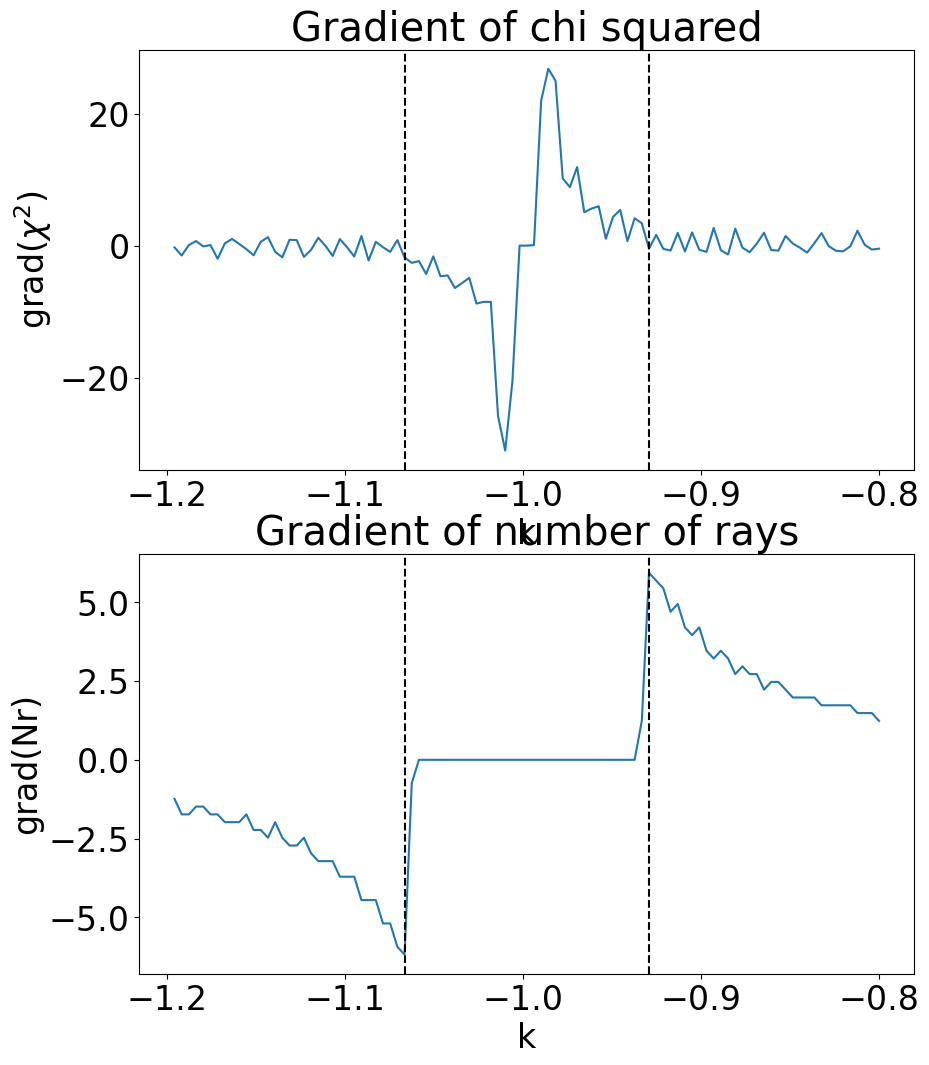

In [17]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,12))
grad_chi=np.diff(chis)/np.diff(np.linspace(-1.2,-0.8,100))
num=(1000-np.array(nr))/1000
grad_nr=np.diff(num)/np.diff(np.linspace(-1.2,-0.8,100))
k_val=np.linspace(-1.2,-0.8,100)[1:]
ax1.plot(k_val,grad_chi)
ax2.plot(k_val,grad_nr)
kmin=k_val[np.argmin(grad_nr)]
kmax=k_val[np.argmax(grad_nr)]
ax2.axvline(kmin,color='k', linestyle='--')
ax2.axvline(kmax,color='k', linestyle='--')
ax1.axvline(kmin,color='k', linestyle='--')
ax1.axvline(kmax,color='k', linestyle='--')
ax1.set_title('Gradient of chi squared')
ax2.set_title('Gradient of number of rays')
ax1.set_xlabel('k')
ax2.set_xlabel('k')
ax1.set_ylabel(r'grad($\chi^2$)')
ax2.set_ylabel(r'grad(Nr)')
# plt.savefig('brute_gradient.png')
plt.show()

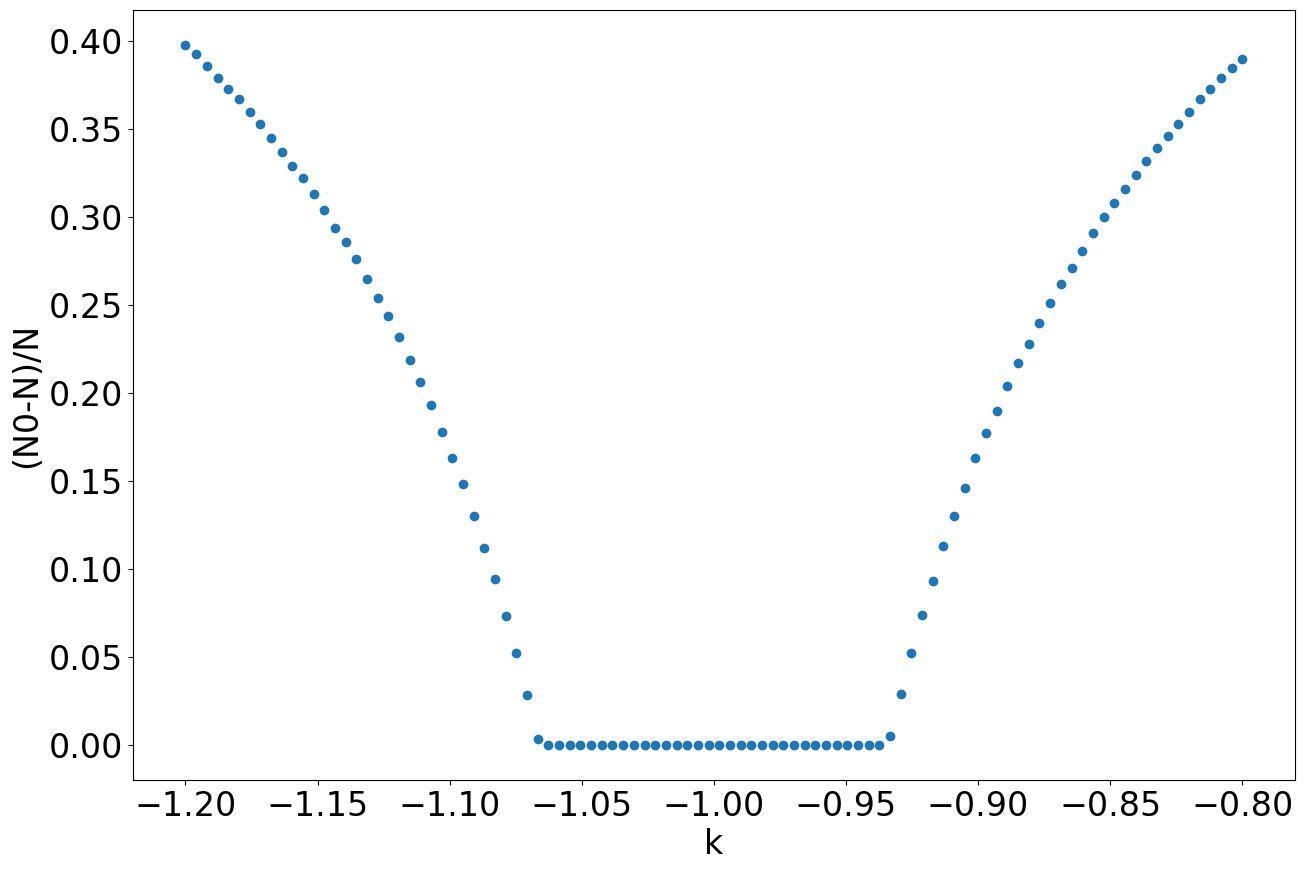

In [18]:
plt.figure(figsize=(15,10))
plt.scatter(np.linspace(-1.2,-0.8,100),(1000-np.array(nr))/1000)
plt.xlabel("k")
plt.ylabel('(N0-N)/N')
plt.savefig('n_rays.png')

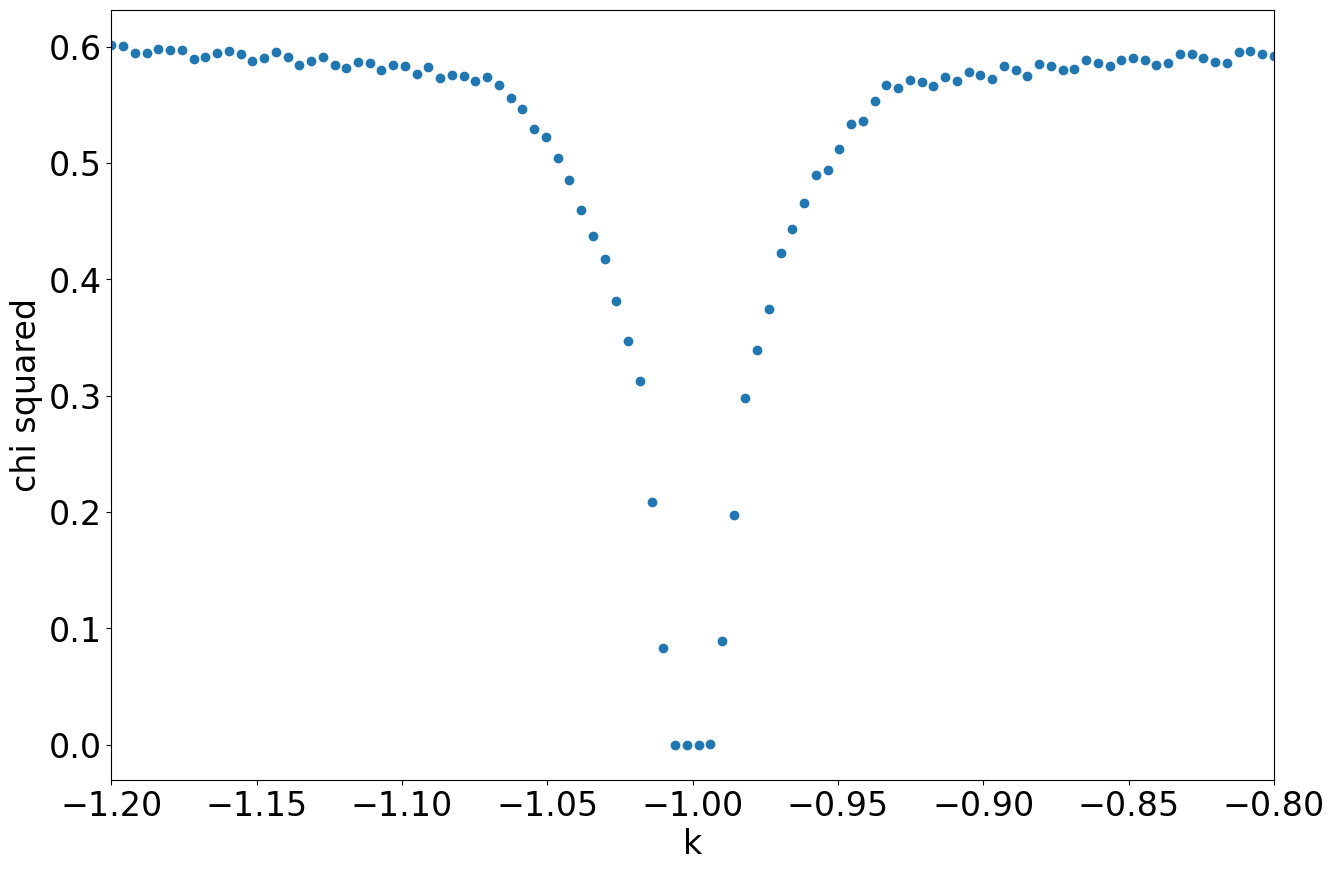

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(np.linspace(-1.2,-0.8,len(chis)),chis)
plt.xlabel("k")
plt.ylabel('chi squared')
plt.xlim((-1.2,-0.8))
plt.savefig('chi_squared.png')

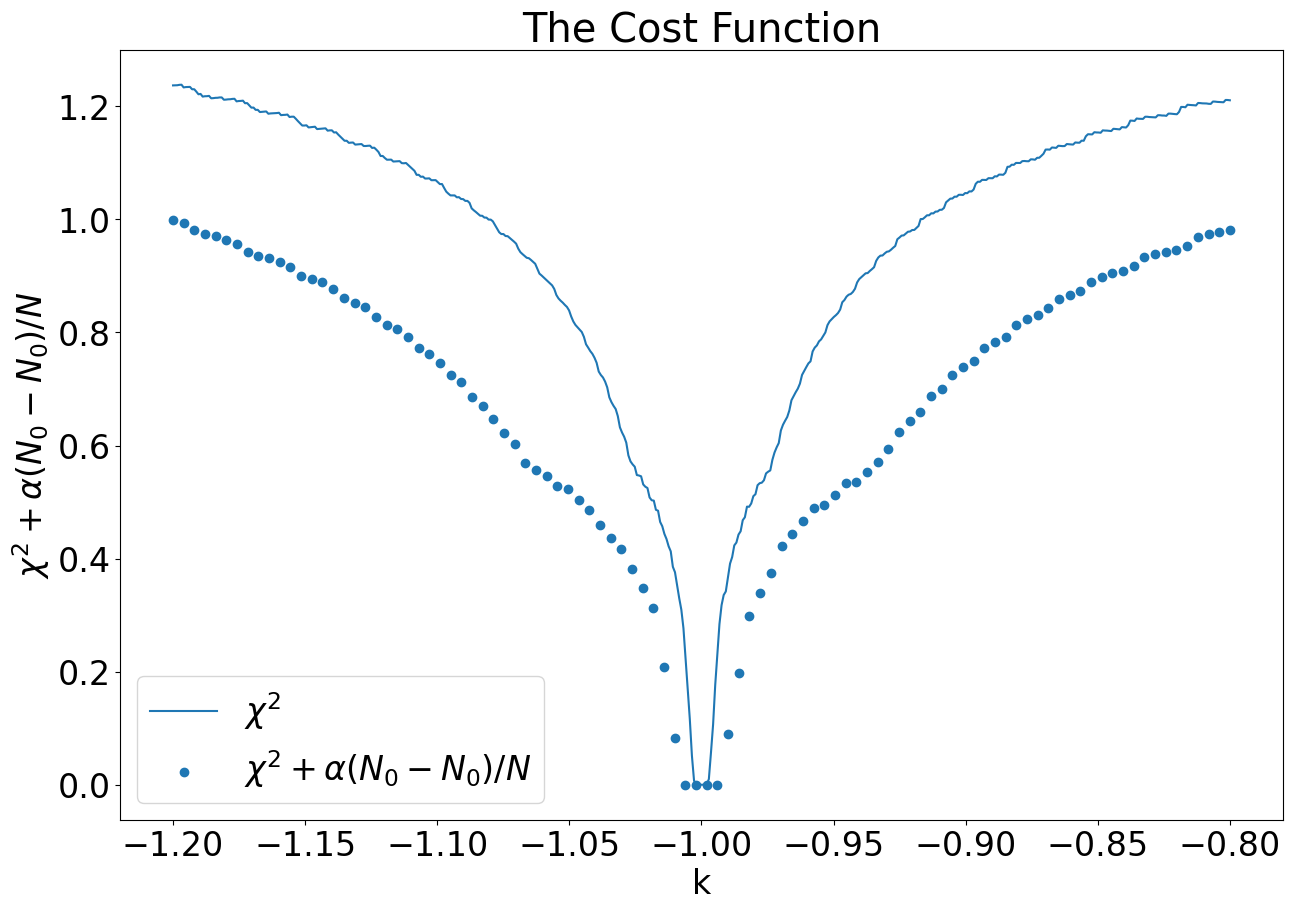

In [20]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(-1.2,-0.8,len(cost)),cost, label=r'$\chi^2$')
plt.scatter(np.linspace(-1.2,-0.8,100),chis+(1000-np.array(nr))/1000, label=r'$\chi^2+\alpha(N_0-N_0)/N$')
plt.xlabel("k")
plt.ylabel(r'$\chi^2+\alpha(N_0-N_0)/N$')
plt.title('The Cost Function')
plt.legend()
plt.savefig('cost_function.png')

## The Gradient Descent Algorithm

In [21]:
def gradient_descent(start_k,Del_k,alpha,thick,roc,exp_f,learn_rate,n_iter,tol=1e-6,Nr=1000):
    k=start_k
    ks=[start_k]
    c1=run_raytrace(k,thick,roc,exp_f,Nr)
    cost=[cost_function(c1,alpha,Nr)]
    n=0
    diff=1e6
    while(n<n_iter and abs(diff)>tol and abs(k)<8):
        diff=-learn_rate*grad(k,Del_k,alpha,thick,roc,exp_f,Nr)
        print("%d \t k:%f \t diff:%f"%(n,k,diff))
        k+=diff
        ks.append(k)
        cost.append(cost_function(run_raytrace(k,thick,roc,exp_f,Nr),alpha,Nr))
        n+=1
    return ks,cost

In [22]:
k1,c1=gradient_descent(-0.5,0.001,1,0.064,0.1125,0.05625,0.05,500)

0 	 k:-0.500000 	 diff:0.002920
1 	 k:-0.497080 	 diff:0.012962
2 	 k:-0.484119 	 diff:-0.115177
3 	 k:-0.599296 	 diff:0.011647
4 	 k:-0.587649 	 diff:0.012260
5 	 k:-0.575388 	 diff:0.004082
6 	 k:-0.571306 	 diff:0.004431
7 	 k:-0.566876 	 diff:0.000955
8 	 k:-0.565921 	 diff:0.004292
9 	 k:-0.561629 	 diff:0.011114
10 	 k:-0.550514 	 diff:-0.105607
11 	 k:-0.656122 	 diff:0.010559
12 	 k:-0.645563 	 diff:-0.002145
13 	 k:-0.647707 	 diff:-0.089358
14 	 k:-0.737066 	 diff:0.004296
15 	 k:-0.732769 	 diff:0.000231
16 	 k:-0.732538 	 diff:-0.004492
17 	 k:-0.737030 	 diff:0.004296
18 	 k:-0.732733 	 diff:0.000231
19 	 k:-0.732502 	 diff:-0.004492
20 	 k:-0.736994 	 diff:0.004296
21 	 k:-0.732698 	 diff:-0.001177
22 	 k:-0.733874 	 diff:0.002832
23 	 k:-0.731042 	 diff:0.002838
24 	 k:-0.728205 	 diff:-0.000695
25 	 k:-0.728900 	 diff:-0.085604
26 	 k:-0.814503 	 diff:-0.230684
27 	 k:-1.045187 	 diff:0.316100
28 	 k:-0.729087 	 diff:-0.085604
29 	 k:-0.814691 	 diff:-0.221474
30 	 k:-

In [23]:
k2,c2=gradient_descent(-1.5,0.001,1,0.064,0.1125,0.05625,0.05,500)

0 	 k:-1.500000 	 diff:-0.003821
1 	 k:-1.503821 	 diff:-0.004065
2 	 k:-1.507886 	 diff:-0.005237
3 	 k:-1.513123 	 diff:-0.006044
4 	 k:-1.519168 	 diff:-0.011543
5 	 k:-1.530711 	 diff:-0.016767
6 	 k:-1.547478 	 diff:-0.007219
7 	 k:-1.554698 	 diff:-0.008102
8 	 k:-1.562799 	 diff:-0.014516
9 	 k:-1.577315 	 diff:-0.006211
10 	 k:-1.583526 	 diff:-0.013635
11 	 k:-1.597160 	 diff:-0.007007
12 	 k:-1.604167 	 diff:-0.003830
13 	 k:-1.607997 	 diff:-0.004109
14 	 k:-1.612106 	 diff:0.138077
15 	 k:-1.474029 	 diff:-0.012101
16 	 k:-1.486130 	 diff:-0.007313
17 	 k:-1.493443 	 diff:-0.001180
18 	 k:-1.494623 	 diff:-0.015237
19 	 k:-1.509860 	 diff:-0.006012
20 	 k:-1.515872 	 diff:-0.011796
21 	 k:-1.527668 	 diff:-0.012749
22 	 k:-1.540417 	 diff:-0.002393
23 	 k:-1.542810 	 diff:0.112534
24 	 k:-1.430276 	 diff:-0.010291
25 	 k:-1.440567 	 diff:0.113810
26 	 k:-1.326756 	 diff:-0.009288
27 	 k:-1.336044 	 diff:-0.006615
28 	 k:-1.342659 	 diff:0.089192
29 	 k:-1.253467 	 diff:-0.0

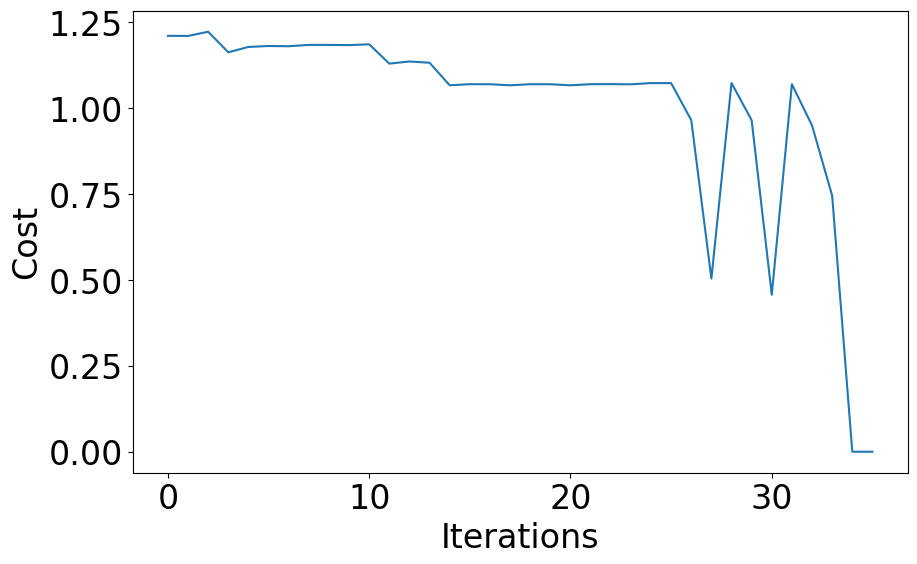

In [24]:
plt.figure(figsize=(10,6))
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.plot(c1)
plt.savefig('cost1')
plt.show()

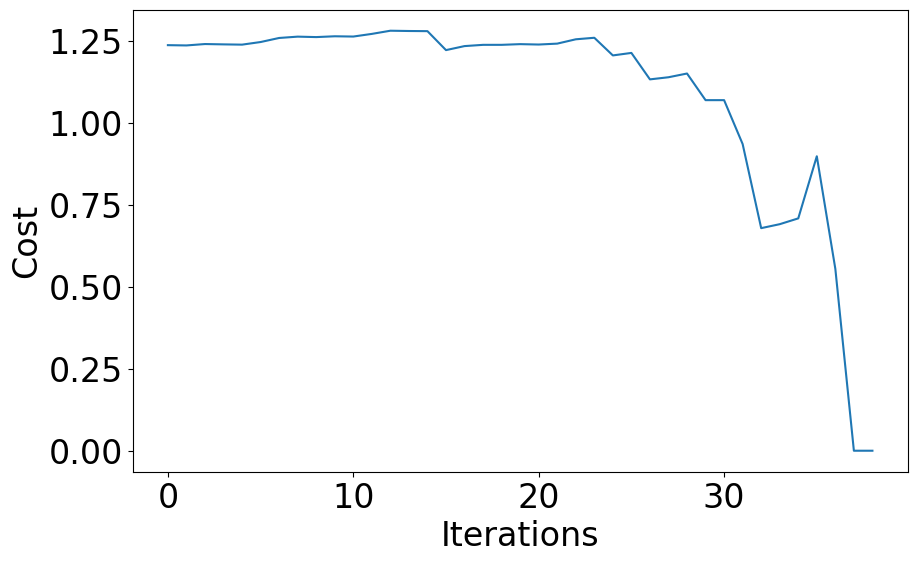

In [25]:
plt.figure(figsize=(10,6))
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.plot(c2)
plt.savefig('cost2')
plt.show()

In [26]:
phi = np.linspace(0, 2*np.pi, 35)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1.+np.cos(phi          )), # scaled to [0,1]
    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

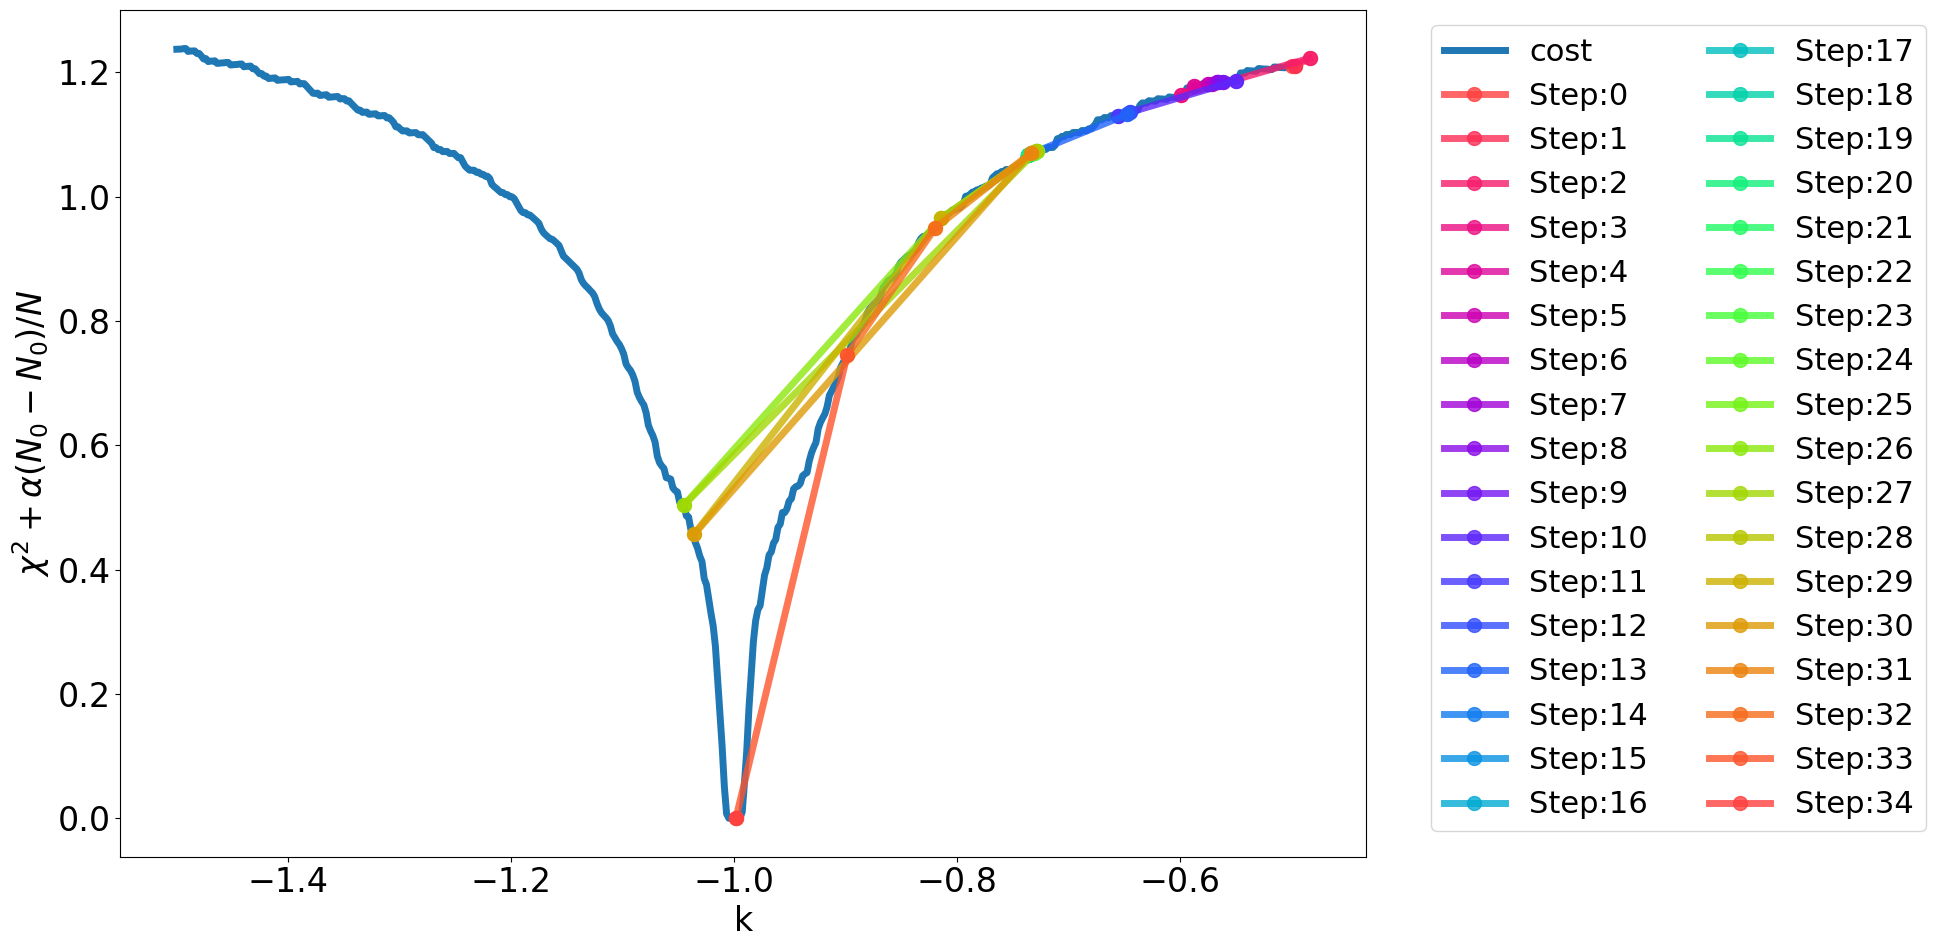

In [27]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(np.linspace(-1.5,-0.5,len(cost)),cost,linewidth=5,label='cost')
for i in range(35):
    ax.plot(k1[i:i+2],c1[i:i+2],'-o',c=rgb_cycle[i],label="Step:"+str(i),linewidth=5,markersize=10,alpha=0.8)
ax.set_xlabel("k")
ax.set_ylabel(r'$\chi^2+\alpha(N_0-N_0)/N$')
#ax.set_xlim((-1.2,-0.8))
#ax.set_title('Gradient Descent Starting from k=-0.5')
ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=2, prop={'size': 22})
plt.tight_layout()
plt.savefig('grad-0_5_alt_font_28.png')
plt.show()

In [28]:
phi = np.linspace(0, 2*np.pi, 38)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1.+np.cos(phi          )), # scaled to [0,1]
    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

In [29]:
len(c2)

39

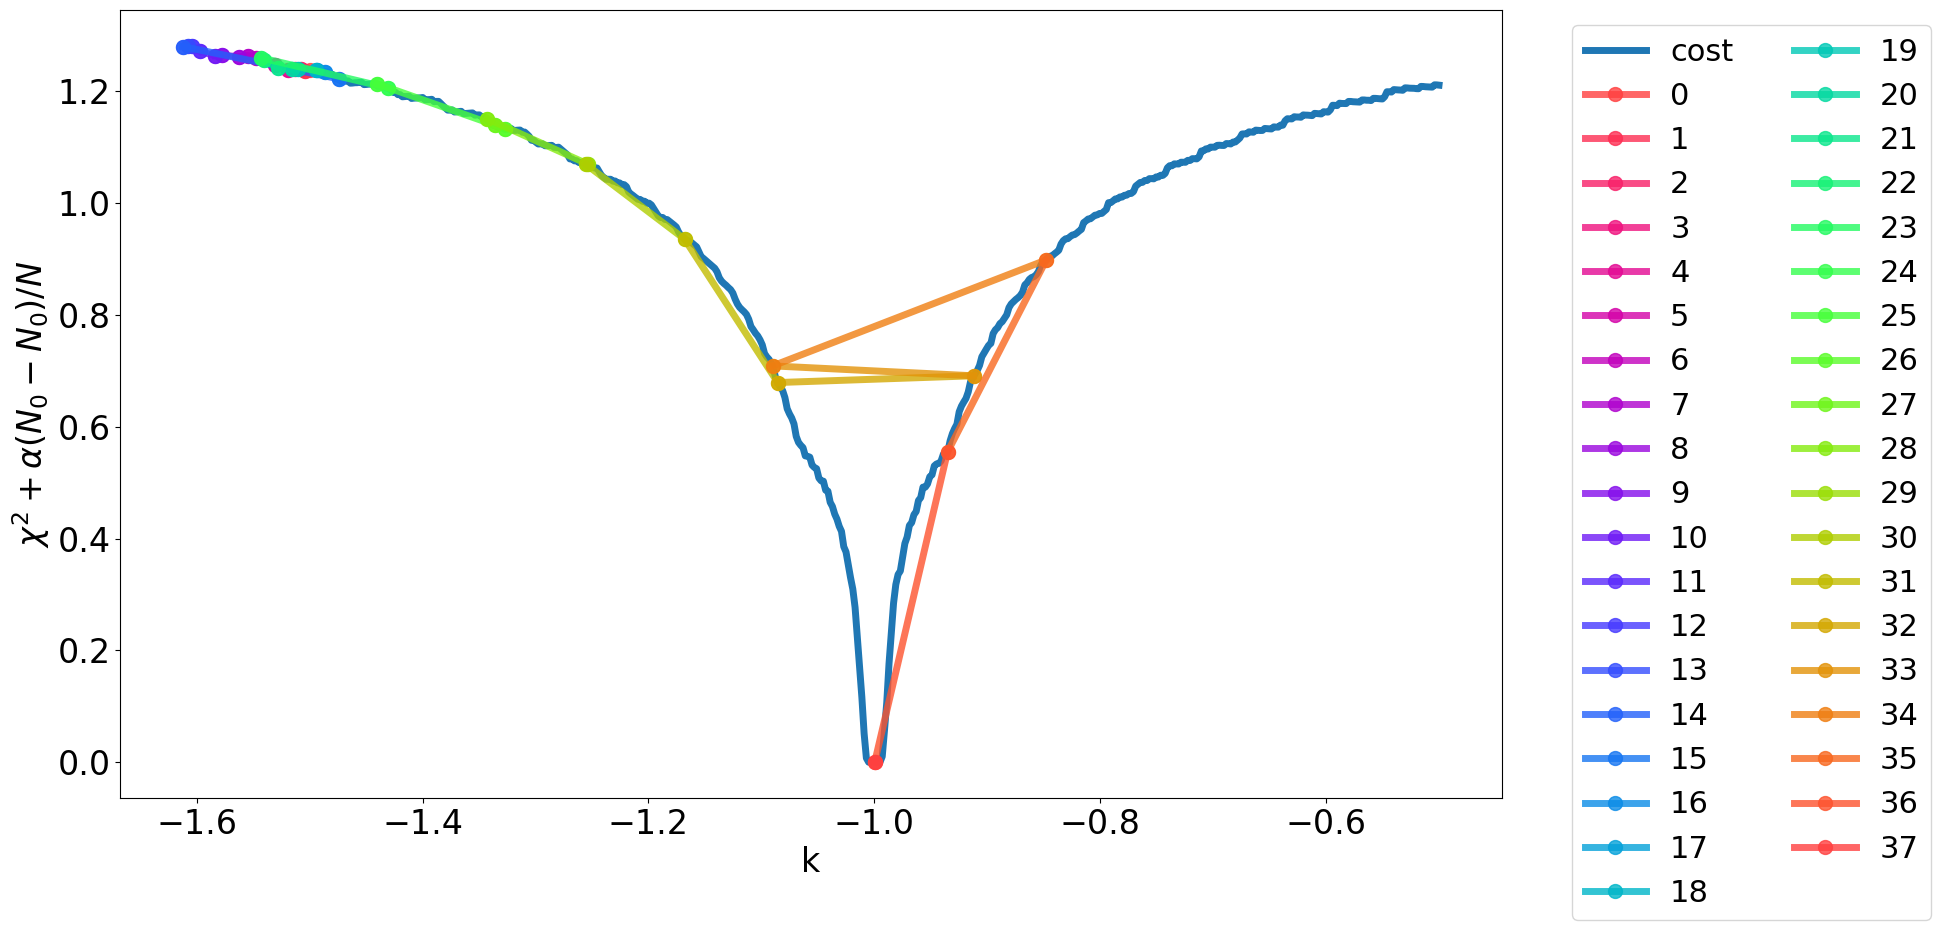

In [30]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(np.linspace(-1.5,-0.5,len(cost)),cost,linewidth=5,label='cost')
for i in range(38):
    ax.plot(k2[i:i+2],c2[i:i+2],'-o',c=rgb_cycle[i],label=str(i),linewidth=5,markersize=10,alpha=0.8)
ax.set_xlabel("k")
ax.set_ylabel(r'$\chi^2+\alpha(N_0-N_0)/N$')
#ax.set_xlim((-1.2,-0.8))
#ax.set_title('Gradient Descent Starting from k=-1.5')
ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=2, prop={'size': 22})
plt.tight_layout()
plt.savefig('grad-1_5_alt_font_28.png')
plt.show()